# 1 - Package import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pyodbc 
import itertools

%matplotlib inline

# 2 - Data retrieval

## 2.1-Basic set up

In [2]:
'''
country index mapping
'''
index_mapping={'AU':"AS51 Index",
        "AV":"SX5E Index",
        "BB":"SX5E Index",
        "CN":"SPX Index",
        "CT":"SPX Index",
        "DC":"SX5E Index",
        "FH":"SX5E Index",
        "FP":"SX5E Index",
        "GY":"SX5E Index",
        "GR":"SX5E Index",       
        "HK":"HSI Index",
        "ID":"SX5E Index",
        "IM":"SX5E Index",
        "JP":"TPX Index",
        "JT":"TPX Index",
        "KS":"KOSPI Index",
        "LN":"SX5E Index",
        "NA":"SX5E Index",
        "NO":"SX5E Index",
        "PL":"SX5E Index",
        "SM":"SX5E Index",
        "SQ":"SX5E Index",
        "SS":"SX5E Index",
        "SW":"SX5E Index",
        "UN":"SPX Index",
        "US":"SPX Index",
        "VX":"SX5E Index",
        "IR":"SX5E Index",
        "LI":"SX5E Index",
        "TT":"TAMSCI Index"}

In [3]:
def universe_evaluate(country,mapping_df):
    if mapping_df[country]=="SPX Index":
        return "US"
    elif mapping_df[country]=="SX5E Index":
        return "Europe"
    else:
        return "Asia"

In [4]:
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [5]:
def unique_date(overlapping_df,column_name):
    '''
    transform the dataframe with overlapping date index to a dataframe with unique date
    '''
    my_df=pd.DataFrame()
    for i in sorted(set(overlapping_df.index.tolist())):
        data_row=overlapping_df[overlapping_df.index==i][[column_name,'Signal']].T
        data_row.columns=data_row.iloc[-1]
        data_row=data_row.iloc[:-1]
        data_row.index=[i]
        my_df=pd.concat([my_df,data_row],axis=0)      
    
    return my_df

## 2.2 - FI val book information upload


In [6]:
def original_book_transform(daily_df,capital,mapping_df,length_boundary):
    '''
    daily df - daily trading data
    Transform into both size_df and pnl_df
    '''
    daily_df["Signal"]=list(zip(daily_df["Ticker"],daily_df["Start"]))
    size_df=unique_date(daily_df,'Exposure')/capital
    pnl_df=unique_date(daily_df,'PNL')/capital

    count_df=pnl_df.copy()
    count_df[pd.notnull(count_df)]=1

    adj_size_df=size_df.loc[:,count_df.sum(axis=0)>length_boundary]
    adj_pnl_df=pnl_df.loc[:,count_df.sum(axis=0)>length_boundary]
    
    country=adj_size_df.apply(lambda x:mapping_df[x.name[0][-2:]] if x.name[0][-2:] in mapping_df.keys() else None,axis=0)
    alpha_size_df=adj_size_df.loc[:,country.dropna().index]
    alpha_pnl_df=adj_pnl_df.loc[:,country.dropna().index]
    
#     size_copy=adj_size_df.T.copy()
#     size_copy["country"]=country
#     size_copy=size_copy[country.dropna()] #get rid of countries that are not in the mapping
#     alpha_size_df=size_copy.T.iloc[:-1]

#     pnl_copy=adj_pnl_df.T.copy()
#     pnl_copy["country"]=country
#     pnl_copy=pnl_copy.loc[pd.notnull(pnl_copy["country"])] #get rid of countries that are not in the mapping
#     alpha_pnl_df=pnl_copy.T.iloc[:-1]    
    return alpha_size_df,alpha_pnl_df
    

In [7]:
JD_FI_daily=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\JD daily data.xlsx',sheet_name='FI'))
JD_ST_daily=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\JD daily data.xlsx',sheet_name='ST'))
FI_VAL_daily=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\FI Val daily data.xlsx',sheet_name='Daily'))

In [75]:
FI_VAL_daily=FI_VAL_daily[FI_VAL_daily.Ticker!='BBD/B CN']

In [8]:
JD_FI_size,JD_FI_pnl=original_book_transform(JD_FI_daily,5*(10**8),index_mapping,5)

In [9]:
JD_ST_size,JD_ST_pnl=original_book_transform(JD_ST_daily,5*(10**8),index_mapping,5)

In [78]:
alpha_FI_size,alpha_FI_pnl=original_book_transform(FI_VAL_daily,1*(10**9),index_mapping,5)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
'''Export the tickers'''
pd.Series(list(set([x[0] for x in alpha_FI_size.columns]))).to_csv("centre book ticker.csv")

In [301]:
pd.Series(list(set([x[0] for x in JD_ST_size.columns]+[x[0] for x in JD_VAL_size.columns]))).to_csv("JD ticker.csv")

## 2.3 fundamental data

In [21]:
'''
Import the fundamental data
'''
US=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\Fundamental data.xlsx',\
                                       sheet_name='US'))
Asia_Europe=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\Fundamental data.xlsx',\
                                       sheet_name='Asia Europe'))
Book=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\Fundamental data.xlsx',\
                                       sheet_name='Book'))

In [22]:
'''
Get rid of equity from the ticker
'''
US.index=[x[:-7] for x in US.copy().index]
Asia_Europe.index=[x[:-7] for x in Asia_Europe.copy().index]
Book.index=[x[:-7] for x in Book.copy().index]
Global=US.append(Asia_Europe).append(Book)
Asia=Asia_Europe.loc[Asia_Europe.apply(lambda x: universe_evaluate(x.name[-2:],index_mapping),axis=1)=="Asia"]
Europe=Asia_Europe.loc[Asia_Europe.apply(lambda x: universe_evaluate(x.name[-2:],index_mapping),axis=1)=="Europe"]

In [23]:
fundamental_dict={'US':US,
                 'Europe':Europe,
                 'Asia': Asia}

In [15]:
'''Export the fundamental universe for data downloading'''
universe=pd.Series(list(set(Global.index))+list(set(index_mapping.values())))
universe.to_csv("Centre book project universe.csv")

In [18]:
'''Grab all the price data for the universe and calculate return '''

Price=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\Fundamental data.xlsx',\
                                       sheet_name='Universe'))
abs_return=Price.T.diff()/Price.T.shift(1)
abs_return=abs_return.T.drop_duplicates().T
abs_return.columns=[x[:-7] if x[-1]=='y' else x for x in abs_return.columns]# get rid of Equity from the ticker

In [19]:
Price_JD=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Center Book\JD daily data.xlsx',\
                                       sheet_name='Price'))
Price_JD=Price_JD.iloc[:,1:]
abs_return_JD=Price_JD.T.diff()/Price_JD.T.shift(1)
abs_return_JD=abs_return_JD.T.drop_duplicates().T
abs_return_JD.columns=[x[:-7] if x[-1]=='y' else x for x in abs_return_JD.columns]# get rid of Equity from the ticker

# 3 - utility functions

In [11]:
def trading_analytics(daily_pnl_df):
    '''
    Key portfolio metrics from portfolio cache
    Feed into plot function
    '''
    
    ind_return=daily_pnl_df.sum(axis=0)
    signal_count=len(ind_return)
    account_curve=daily_pnl_df.cumsum().ffill().sum(axis=1)
    
    if signal_count==0:
        return None,None,None,None,None,None,None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=(account_price.iloc[-1]**(1/len(account_price)))**260-1
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [12]:
def quartile_name(target_series,large):
    '''
    Input input data: target_series to run quartile analysis, large ranks higher if true
    Output: pandas series that contains the quartile score
    '''
    quartile_series=target_series.copy()
    if large:
        quartile_series[target_series>target_series.quantile(0.8)]=1
        quartile_series[(target_series>target_series.quantile(0.6))&(target_series<=target_series.quantile(0.8))]=2
        quartile_series[(target_series>target_series.quantile(0.4))&(target_series<=target_series.quantile(0.6))]=3
        quartile_series[(target_series>target_series.quantile(0.2))&(target_series<=target_series.quantile(0.4))]=4
        quartile_series[target_series<=target_series.quantile(0.2)]=5
    else:
        quartile_series[target_series>target_series.quantile(0.8)]=5
        quartile_series[(target_series>target_series.quantile(0.6))&(target_series<=target_series.quantile(0.8))]=4
        quartile_series[(target_series>target_series.quantile(0.4))&(target_series<=target_series.quantile(0.6))]=3
        quartile_series[(target_series>target_series.quantile(0.2))&(target_series<=target_series.quantile(0.4))]=2
        quartile_series[target_series<=target_series.quantile(0.2)]=1
    return quartile_series

In [13]:
def factor_rank_transform(fundamental_df):
    '''
    three factor version
    '''
    fundamental_df.loc[:,"mom"]=fundamental_df.apply(lambda x:x["RECENT PRICE"]/x["BEFORE PRICE"]-1 \
                                                     if np.isreal(x["BEFORE PRICE"]) \
             and np.isreal(x["RECENT PRICE"]) else None, axis=1)
    
    fundamental_df.loc[:,"value"]=fundamental_df.apply(lambda x:x["BOOK"]/x["Market Cap"] if np.isreal(x["BOOK"]) \
             and np.isreal(x["Market Cap"]) else None, axis=1)
    
    fundamental_df.loc[:,"size"]=fundamental_df.apply(lambda x: x["Market Cap"] if np.isreal(x["Market Cap"]) else None, axis=1)
    
    fundamental_df=fundamental_df[np.isfinite(fundamental_df["mom"])]
    fundamental_df=fundamental_df[np.isfinite(fundamental_df["value"])]
    fundamental_df=fundamental_df[np.isfinite(fundamental_df["size"])]
    
    fundamental_df.loc[:,"size_rank"]=quartile_name(fundamental_df["size"],False)
        
    size_mom=pd.Series()
    for i in set(fundamental_df["size_rank"]):
        target=fundamental_df[fundamental_df["size_rank"]==i]
        target["size_mom"]=list(zip(target["size_rank"],quartile_name(target["mom"],True)))
        size_mom=size_mom.append(target["size_mom"])

    fundamental_df.loc[:,"size_mom"]=size_mom
        
    size_mom_value=[]
    for i in set(fundamental_df["size_mom"]):
        target=fundamental_df[fundamental_df["size_mom"]==i]
        target["size_mom_value"]=list(zip(list(zip(*target["size_mom"]))[0],list(zip(*target["size_mom"]))[1],\
                                          quartile_name(target["value"],True)))
        size_mom_value.append(target["size_mom_value"])
    
    
    fundamental_df.loc[:,"size_mom_value"]=pd.concat(size_mom_value,axis=0)
    
    return fundamental_df

# 4 - Signal class
 - Index
 - Factor
 - Separate combination function

In [14]:
class signal(object):
    '''
    generate signal account for index hedged portfolio
    '''
    def __init__(self,return_df,orig_size_df,orig_pnl_df,book_df,mapping_df,sizing,new_size,region,fundamental_dict):
        self.return_df=return_df
        self.mapping_df=mapping_df
        self.sizing=sizing
        self.region=region
        self.book_df=book_df
        self.new_size=new_size
        self.fundamental_dict=fundamental_dict
        
        if region=="Global":
            self.orig_alpha_size=orig_size_df
            self.orig_alpha_pnl=orig_pnl_df
        else:
            self.orig_alpha_size=orig_size_df.loc[:,orig_size_df.apply(lambda x:universe_evaluate(x.name[0][-2:],mapping_df),\
                                                                           axis=0)==region]    
            self.orig_alpha_pnl=orig_pnl_df.loc[:,orig_pnl_df.apply(lambda x:universe_evaluate(x.name[0][-2:],mapping_df),\
                                                                           axis=0)==region]   
    def index_signal_account(self):

        '''
        Build signal account from original size dataframe, and apply to different sizing scheme, hedged with market index
        Sizing:
        - original
        - entry
        - average
        - equal
        - risk parity
        '''
        
        orig_alpha_size=self.orig_alpha_size.copy()
        
        alpha_count_df=orig_alpha_size.copy()
        alpha_count_df[pd.notnull(alpha_count_df)]=1

        alpha_return_df=self.return_df[[x[0] for x in alpha_count_df.columns]].loc[alpha_count_df.index]
        alpha_return_df.columns=self.orig_alpha_size.columns
        alpha_signal_df=alpha_return_df*alpha_count_df

        if self.sizing=="original":
            alpha_size_df=orig_alpha_size
        else:
            if self.sizing=="entry":
                size_row=orig_alpha_size.apply(lambda x: x.dropna().iloc[0],axis=0)
            elif self.sizing=="average":
                size_row=orig_alpha_size.mean(axis=0)
            elif self.sizing=="equal":
                size_row=orig_alpha_size.apply(lambda x:self.new_size if x.mean()>0 else -self.new_size,axis=0)
            elif self.sizing=="risk parity":
                vol_row=orig_alpha_size.apply(lambda x:self.return_df[x.name[0]].loc[:x.name[1]][-30:].std(),axis=0)
                size_row=(vol_row.mean()/vol_row).fillna(1.0)*orig_alpha_size.apply(lambda x:self.new_size \
                                                                                    if x.mean()>0 else -self.new_size,axis=0)
            self.size_row=size_row
            self.trial=orig_alpha_size
            
            alpha_size_df=(1+alpha_signal_df).cumprod()*size_row

        index_series=alpha_size_df.apply(lambda x:index_mapping[x.name[0][-2:]],axis=0)
        alpha_size_df_copy=alpha_size_df.T
        alpha_size_df_copy["Index"]=index_series
        index_size_df=(alpha_size_df_copy.groupby("Index").apply(sum)*-1).T.iloc[:-1]
        index_signal_df=self.return_df[list(set(index_series.dropna()))].loc[alpha_signal_df.index]

        total_signal_df=pd.concat([alpha_signal_df,index_signal_df],axis=1)
        total_size_df=pd.concat([alpha_size_df,index_size_df],axis=1)
        total_daily_pnl=total_size_df.shift(1)*total_signal_df
        total_account_curve=total_daily_pnl.cumsum().ffill().sum(axis=1)
        total_ind_return=total_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        total_cache=(total_daily_pnl,total_account_curve,total_size_df,total_ind_return,total_signal_df)

        alpha_daily_pnl=alpha_size_df.shift(1)*alpha_return_df
        alpha_account_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_ind_return=alpha_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        alpha_cache=(alpha_daily_pnl,alpha_account_curve,alpha_size_df,alpha_ind_return,alpha_signal_df)

        long_size_df=alpha_size_df.loc[:,alpha_size_df.mean(axis=0)>0]
        long_daily_pnl=alpha_daily_pnl.loc[:,long_size_df.columns]
        long_account_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
        long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
        long_signal_df=alpha_signal_df.loc[:,long_size_df.columns]

        long_cache=(long_daily_pnl,long_account_curve,long_size_df,long_ind_return,long_signal_df)

        short_size_df=alpha_size_df.loc[:,alpha_size_df.mean(axis=0)<0]
        short_daily_pnl=alpha_daily_pnl.loc[:,short_size_df.columns]
        short_account_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
        short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
        short_signal_df=alpha_signal_df.loc[:,short_size_df.columns]

        short_cache=(short_daily_pnl,short_account_curve,short_size_df,short_ind_return,short_signal_df)   
        
        'Assign portfolio data for later use'
        self.index_hedged_portfolio=total_cache
        self.index_hedged_alpha=alpha_cache
        self.index_hedged_long=long_cache
        self.index_hedged_short=short_cache
        
        return long_cache,short_cache,alpha_cache,total_cache

    def factor_universe(self):
        '''
        Work out factor df from fundamental _df
        '''
        
        book_universe=self.book_df.apply(lambda x:universe_evaluate(x.name[-2:],self.mapping_df),axis=1)
        book_region=self.book_df[book_universe==self.region]

        factor_list=[]

        adj_fundamental_df=pd.concat([self.fundamental_dict[self.region],book_region],axis=0).drop_duplicates()

        for i in list(sorted(set(adj_fundamental_df["Date"]))):
            target_df=adj_fundamental_df[adj_fundamental_df["Date"]==i]
            target_series=factor_rank_transform(target_df)["size_mom_value"]
            target_series.name=i
            factor_list.append(target_series)

        factor_df=pd.concat(factor_list,axis=1)

        factor_universe_df=factor_df.T.resample('B').ffill().shift(1)
        factor_universe_df.iloc[1]=factor_universe_df.iloc[2]
        factor_universe_df=factor_universe_df.iloc[1:]
        
        'Assign it for later use' 
        self.factor_universe_df=factor_universe_df
        
        return factor_universe_df    

    def factor_return(self):
        '''
        Get factor return df from stock/factor mapping
        Rebalanced every month
        '''
        
        try:
            factor_universe_df=self.factor_universe_df.copy()
        except:
            factor_universe_df=signal.factor_universe(self)
        
        factor_return_dict={}
        target_return=self.return_df.T.loc[self.factor_universe_df.columns].T
        date_mapping=pd.Series([(x.year,x.month) for x in self.factor_universe_df.index],index=self.factor_universe_df.index)
        #rebalancing

        for i in sorted(list(set(self.factor_universe_df.unstack(-1).dropna()))):#get a list of unique factors
            factor_copy=self.factor_universe_df.copy()
            factor_evaluate=factor_copy.apply(lambda x: x[x==i],axis=1)
            factor_evaluate[pd.notnull(factor_evaluate)]=1
            factor_return_sub=(factor_evaluate*target_return).dropna(how='all',axis=1)
            factor_return_month_list=[]
            for s in sorted(list(set(date_mapping))):# we have all the stocks, average them out with equal weighting index
                return_month=factor_return_sub.loc[date_mapping[date_mapping==s].index]
                return_month_cum=(1+return_month).cumprod().mean(axis=1).fillna(1.0)
                factor_return_month=return_month_cum.diff(1)/return_month_cum.shift(1)
                factor_return_month.iloc[0]=return_month_cum.iloc[0]-1
                factor_return_month_list.append(factor_return_month)

            factor_return_dict[i]=pd.concat(factor_return_month_list,axis=0)    
        
        factor_return_df=pd.DataFrame(factor_return_dict)
        self.factor_return_df=factor_return_df
        return factor_return_df
    
    
    def factor_size(self):
        '''
        From portfolio size, factor return and factor universe to get factor size
        '''
        
        try:
            alpha_size_df=self.index_hedged_alpha[2].copy()
        except:
            alpha_size_df=signal.index_signal_account(self)[2][2]
        
        try:
            factor_universe_df=self.factor_universe_df.copy()
        except:
            factor_universe_df=signal.factor_universe(self)
        
        factor_universe_df=factor_universe_df.fillna(1.0)

        count_df=alpha_size_df.copy()
        count_df[pd.notnull(count_df)]=1
        signal_factor_df=count_df.apply(lambda x:\
                                     x*factor_universe_df.loc[:,x.name[0]] if x.name[0] in factor_universe_df.columns else x\
                                     ,axis=0) # generate signal/factor mapping

        residual_size_df=alpha_size_df[signal_factor_df==1].dropna(how='all',axis=1)
        #aim to extract those that are not covered by the factor, used later for hedge with market index


        factor_size_dict={}
        for i in sorted(factor_universe_df.iloc[2][factor_universe_df.iloc[2]!=1].dropna().unique()):
            signal_factor_copy=signal_factor_df.copy()
            signal_factor_evaluate=signal_factor_copy.apply(lambda x: x[x==i],axis=1)
            signal_factor_evaluate[pd.notnull(signal_factor_evaluate)]=1
            factor_size=alpha_size_df.loc[:,signal_factor_evaluate.columns]*signal_factor_evaluate
            if factor_size.shape[1]==0:
                pass
            else:
                factor_size_dict[i]=-factor_size.sum(axis=1)

        factor_size_df=pd.DataFrame(factor_size_dict).loc[alpha_size_df.index]
        
        self.factor_size_df=factor_size_df
        self.residual_size_df=residual_size_df

        return factor_size_df,residual_size_df

    def factor_signal_account(self):
        '''
        Produce factor hedged signal account
        Build on factor_return and factor_size functions
        '''
        
        try:
            alpha_size_df=self.index_hedged_alpha[2].copy()
        except:
            alpha_size_df=signal.index_signal_account(self)[2][2]
        
        try:
            factor_universe_df=self.factor_universe_df.copy()
        except:
            factor_universe_df=signal.factor_universe(self)        
        
        try:
            factor_return_df=self.factor_return_df.copy()
        except:
            factor_return_df=signal.factor_return(self)        

        try:
            factor_size_df=self.factor_size_df.copy()
            residual_size_df=self.residual_size_df.copy()
        except:
            factor_size_df,residual_size_df=signal.factor_size(self)                  


        alpha_count_df=alpha_size_df.copy()
        alpha_count_df[pd.notnull(alpha_count_df)]=1
        alpha_return_df=self.return_df[[x[0] for x in alpha_count_df.columns]].loc[alpha_count_df.index]
        alpha_return_df.columns=alpha_size_df.columns
        alpha_signal_df=alpha_return_df*alpha_count_df

        factor_count_df=factor_size_df.copy()
        factor_count_df[pd.notnull(factor_count_df)]=1
        factor_signal_df=factor_return_df[factor_count_df.columns]*factor_count_df    

        index_series=residual_size_df.apply(lambda x:self.mapping_df[x.name[0][-2:]],axis=0)
        residual_size_copy=residual_size_df.T
        residual_size_copy["Index"]=index_series
        index_size_df=(residual_size_copy.groupby("Index").apply(sum)*-1).T.iloc[:-1]
        index_signal_df=self.return_df[list(set(index_series.dropna()))].loc[alpha_signal_df.index] 

        total_signal_df=pd.concat([alpha_signal_df,factor_signal_df,index_signal_df],axis=1)
        total_size_df=pd.concat([alpha_size_df,factor_size_df,index_size_df],axis=1)
        total_daily_pnl=total_size_df.shift(1)*total_signal_df
        total_account_curve=total_daily_pnl.cumsum().ffill().sum(axis=1)
        total_ind_return=total_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        total_cache=(total_daily_pnl,total_account_curve,total_size_df,total_ind_return)

        alpha_daily_pnl=total_daily_pnl.loc[:,alpha_size_df.columns]
        alpha_account_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_ind_return=alpha_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        alpha_cache=(alpha_daily_pnl,alpha_account_curve,alpha_size_df,alpha_ind_return)

        long_size_df=alpha_size_df.loc[:,alpha_size_df.mean(axis=0)>0]
        long_daily_pnl=alpha_daily_pnl.loc[:,long_size_df.columns]
        long_account_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
        long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        long_cache=(long_daily_pnl,long_account_curve,long_size_df,long_ind_return)

        short_size_df=alpha_size_df.loc[:,alpha_size_df.mean(axis=0)<0]
        short_daily_pnl=alpha_daily_pnl.loc[:,short_size_df.columns]
        short_account_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
        short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()

        short_cache=(short_daily_pnl,short_account_curve,short_size_df,short_ind_return)    
        
        'Assign portfolio data for later use'
        self.factor_hedged_portfolio=total_cache
        self.factor_hedged_alpha=alpha_cache       
        self.factor_hedged_long=long_cache
        self.factor_hedged_short=short_cache
        
        return long_cache,short_cache,alpha_cache,total_cache

In [45]:
def plot_signal(title,figsize,portfolio_cache):

    account_curve=portfolio_cache[1]
    avg_size=np.abs(portfolio_cache[2]).mean(axis=0).mean()
    ind_return=portfolio_cache[3]
    gross=np.abs(portfolio_cache[2]).sum(axis=1)
    net=portfolio_cache[2].sum(axis=1)
    turnover=(np.abs(portfolio_cache[2].fillna(0.0).diff(1)).sum().sum())/(portfolio_cache[2].shape[0]/260)

    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])

    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')
    ln3=ax2.plot(net,label='net',color='orange')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])

    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics(portfolio_cache[0])

    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2+ln3,[l.get_label() for l in ln1+ln2+ln3],loc=2)
    ax1.axhline(y=0,color='k')

    plt.show()        

In [41]:
def signal_combine(cache_list,capital_reference,target_capital):
    '''
    Assume all the signal class follows the same capital base
    '''
    daily_pnl_df=pd.DataFrame()
    size_df=pd.DataFrame()
    
    for i in cache_list:
        daily_pnl_df=pd.concat([daily_pnl_df,i[0]*target_capital/capital_reference],axis=1)
        size_df=pd.concat([size_df,i[2]*target_capital/capital_reference],axis=1)
    
    account_curve=daily_pnl_df.cumsum().ffill().sum(axis=1)
    ind_return=daily_pnl_df.cumsum().ffill().iloc[-1].dropna()
    return daily_pnl_df,account_curve,size_df,ind_return
    

In [24]:
JD_FI_orig=signal(abs_return_JD,JD_FI_size,JD_FI_pnl,Book,index_mapping,'original',0.015,"Global",\
                               fundamental_dict)

In [25]:
JD_ST_orig=signal(abs_return_JD,JD_ST_size,JD_ST_pnl,Book,index_mapping,'original',0.015,"Global",\
                               fundamental_dict)

In [29]:
JD_orig_alpha=signal_combine([JD_FI_orig.index_hedged_alpha,JD_ST_orig.index_hedged_alpha], 1,1)

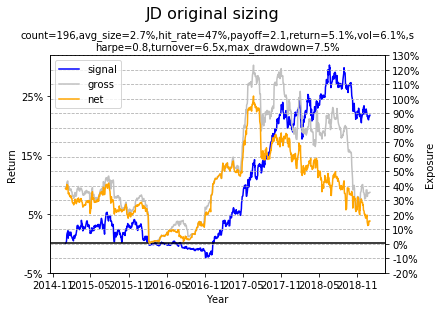

In [46]:
plot_signal('JD original sizing',[6,4],JD_orig_alpha)

In [57]:
JD_orig=signal_combine([JD_FI_orig.index_hedged_portfolio,JD_ST_orig.index_hedged_portfolio], 1,1)

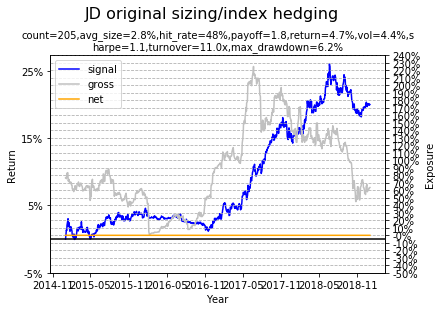

In [58]:
plot_signal('JD original sizing/index hedging',[6,4],JD_orig)

In [459]:
JD_FI_rp=signal(abs_return_JD,JD_FI_size,JD_FI_pnl,Book,index_mapping,'risk parity',0.02,"Global",\
                               fundamental_dict)

In [460]:
JD_ST_rp=signal(abs_return_JD,JD_ST_size,JD_ST_pnl,Book,index_mapping,'risk parity',0.02,"Global",\
                               fundamental_dict)

In [463]:
JD_rp_alpha=signal_combine([JD_FI_rp.index_hedged_alpha,JD_ST_rp.index_hedged_alpha], 1,1)

In [464]:
JD_rp=signal_combine([JD_FI_rp.index_hedged_portfolio,JD_ST_rp.index_hedged_portfolio], 1,1)

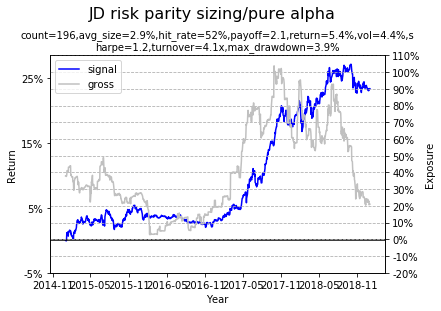

In [499]:
plot_signal('JD risk parity sizing/pure alpha',[6,4],JD_rp_alpha)

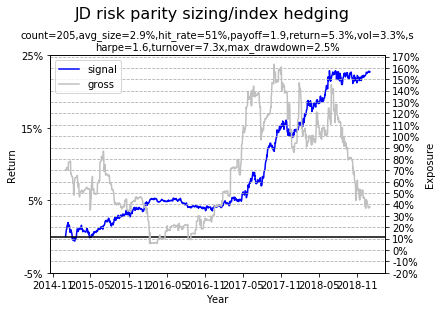

In [500]:
plot_signal('JD risk parity sizing/index hedging',[6,4],JD_rp)

In [503]:
np.abs(JD_rp[2]).sum(axis=1).mean()

0.6833296277275535

## 4.1 Europe

In [79]:
Europe_center_book_orig=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'original',0.015,"Europe",\
                               fundamental_dict)

In [25]:
trading_analytics(Europe_center_book_orig.index_signal_account()[2][0])

(457,
 0.4223194748358862,
 1.887525646944715,
 0.02673466213327247,
 0.038422756851836416,
 0.6958028086418969,
 0.06594538005137629)

In [32]:
trading_analytics(Europe_center_book_orig.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(580,
 0.4413793103448276,
 1.5643772130446976,
 0.02460036058560422,
 0.023727509506176362,
 1.0367864600033414,
 0.025473386455630243)

In [89]:
Europe_center_book_equal=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'equal',0.015,"Europe",\
                             fundamental_dict)

In [90]:
trading_analytics(Europe_center_book_equal.index_signal_account()[2][0])

(457,
 0.48358862144420134,
 1.3195295572812524,
 0.019120824190498542,
 0.035450044391678884,
 0.5393737728290894,
 0.08114025583574525)

In [91]:
trading_analytics(Europe_center_book_equal.index_hedged_portfolio[0])

(458,
 0.4650655021834061,
 1.630714442369059,
 0.03245733252627159,
 0.029692333916826952,
 1.093121632579973,
 0.049802076781311544)

In [92]:
trading_analytics(Europe_center_book_equal.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(580,
 0.46379310344827585,
 1.3391025662820704,
 0.017716778063946448,
 0.020955444167235493,
 0.8454498946697201,
 0.030355927100869318)

In [81]:
Europe_center_book_rp=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'risk parity',0.015,"Europe",\
                             fundamental_dict)

In [34]:
trading_analytics(Europe_center_book_rp.index_signal_account()[2][0])

(457,
 0.48577680525164113,
 1.4534626822124364,
 0.03090056242621131,
 0.03718184815650898,
 0.8310658011442047,
 0.06875966183592175)

In [35]:
trading_analytics(Europe_center_book_rp.index_hedged_portfolio[0])

(458,
 0.4650655021834061,
 1.7423132947792874,
 0.04110542626894409,
 0.033019729160226885,
 1.2448747253341084,
 0.04458224475833206)

In [36]:
trading_analytics(Europe_center_book_rp.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(580,
 0.4689655172413793,
 1.373359537772303,
 0.02535321622775677,
 0.0236656978520075,
 1.071306512332833,
 0.036451571900668944)

## 4.2 - US

In [83]:
US_center_book_orig=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'original',0.015,"US",\
                               fundamental_dict)

In [38]:
trading_analytics(US_center_book_orig.index_signal_account()[2][0])

(250,
 0.424,
 1.8144992687708537,
 0.013344653774101989,
 0.029397906792066508,
 0.45393210708808884,
 0.08093311432246264)

In [39]:
trading_analytics(US_center_book_orig.index_hedged_portfolio[0])

(251,
 0.42231075697211157,
 1.593773020620537,
 0.007882775745464032,
 0.022719206540949645,
 0.3469652750088753,
 0.06293609447986592)

In [40]:
trading_analytics(US_center_book_orig.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(348,
 0.41954022988505746,
 1.4653905818354456,
 0.003957388989093369,
 0.018939794600513007,
 0.208945718396871,
 0.047157628438047494)

In [93]:
US_center_book_equal=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'equal',0.015,"US",\
                             fundamental_dict)

In [94]:
trading_analytics(US_center_book_equal.index_signal_account()[2][0])

(250,
 0.464,
 1.5711226694989437,
 0.015809946535160435,
 0.028636600509867233,
 0.5520888043157514,
 0.06061070832152626)

In [95]:
trading_analytics(US_center_book_equal.index_hedged_portfolio[0])

(251,
 0.47410358565737054,
 1.458306066981798,
 0.014001934842917896,
 0.022009430564264073,
 0.6361788780511358,
 0.04195353591993001)

In [96]:
trading_analytics(US_center_book_equal.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(348,
 0.4511494252873563,
 1.3837004123389651,
 0.0089298205310262,
 0.01855186440684084,
 0.48134356392414157,
 0.028771125552471077)

In [85]:
US_center_book_rp=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'risk parity',0.015,"US",\
                             fundamental_dict)

In [42]:
trading_analytics(US_center_book_rp.index_signal_account()[2][0])

(250,
 0.464,
 1.5934971761379952,
 0.018806351138608512,
 0.030867770338690242,
 0.6092552501285226,
 0.05862797377465012)

In [43]:
trading_analytics(US_center_book_rp.index_hedged_portfolio[0])

(251,
 0.47808764940239046,
 1.5402407198233619,
 0.020201034693318576,
 0.023906312061491557,
 0.8450084078781241,
 0.03441853081103774)

In [44]:
trading_analytics(US_center_book_rp.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(348,
 0.46551724137931033,
 1.4032283874394407,
 0.015531149339424788,
 0.020177121362785603,
 0.7697405918403316,
 0.022130470345674613)

## 4.3 - Asia

In [87]:
Asia_center_book_orig=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'original',0.015,"Asia",\
                               fundamental_dict)

In [46]:
trading_analytics(Asia_center_book_orig.index_signal_account()[2][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5752: RuntimeWarning: '<' not supported between instances of 'str' and 'tuple', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


(13,
 0.6153846153846154,
 3.8225605136580807,
 0.0029818854803713712,
 0.0050856838466460524,
 0.5863293060062884,
 0.006833356831159154)

In [47]:
trading_analytics(Asia_center_book_orig.index_hedged_portfolio[0])

(17,
 0.5294117647058824,
 1.6107335075906444,
 0.0016037102678623238,
 0.004472039948326826,
 0.3586082160250688,
 0.006124157719441414)

In [48]:
trading_analytics(Asia_center_book_orig.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(36,
 0.4444444444444444,
 1.0594487249173397,
 -0.00044933288028858875,
 0.0044501029726160424,
 -0.10097134449552825,
 0.0073511149125801145)

In [89]:
Asia_center_book_equal=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'equal',0.015,"Asia",\
                             fundamental_dict)

In [98]:
trading_analytics(Asia_center_book_equal.index_signal_account()[2][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5752: RuntimeWarning: '<' not supported between instances of 'str' and 'tuple', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


(13,
 0.6153846153846154,
 2.1189669570405463,
 0.002790068409695312,
 0.006826346081328672,
 0.40872062102545154,
 0.01474264431989547)

In [99]:
trading_analytics(Asia_center_book_equal.index_hedged_portfolio[0])

(17,
 0.5882352941176471,
 1.1071440437657754,
 0.001636605162275595,
 0.00609800791880117,
 0.2683835744505464,
 0.00927587789831752)

In [100]:
trading_analytics(Asia_center_book_equal.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(36,
 0.4722222222222222,
 1.2232205962491094,
 0.000442426300101495,
 0.005633162227042382,
 0.0785395985895093,
 0.008498080157816279)

In [65]:
Asia_center_book_rp=signal(abs_return,alpha_FI_size,alpha_FI_pnl,Book,index_mapping,'risk parity',0.015,"Asia",\
                             fundamental_dict)

In [51]:
trading_analytics(Asia_center_book_rp.index_signal_account()[2][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5752: RuntimeWarning: '<' not supported between instances of 'str' and 'tuple', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


(13,
 0.6153846153846154,
 1.7014118384241854,
 0.002804776847562307,
 0.007448922130335544,
 0.37653459097658243,
 0.016837228057054454)

In [52]:
trading_analytics(Asia_center_book_rp.index_hedged_portfolio[0])

(17,
 0.5882352941176471,
 1.0985438839825963,
 0.001809506059353927,
 0.00636595609626826,
 0.28424733566960414,
 0.008717398651622466)

In [53]:
trading_analytics(Asia_center_book_rp.factor_signal_account()[-1][0])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(36,
 0.4722222222222222,
 1.0303259192971517,
 -0.0004805773237802624,
 0.0059845589843512915,
 -0.08030288030194017,
 0.010888896422804883)

## 4.4 - Combine

In [91]:
index_hedged_alpha_combine=signal_combine([Europe_center_book_orig.index_hedged_alpha,
                US_center_book_orig.index_hedged_alpha,
                Asia_center_book_orig.index_hedged_alpha]
               ,1000000000,1000000000)

In [137]:
original_size=index_hedged_alpha_combine[2].mean().sort_index()

In [138]:
original_size.name='Original'

In [139]:
size_df=original_size.to_frame()

In [140]:
size_df.loc[:,"Risk parity"]=index_hedged_alpha_rp_combine[2].mean().sort_index()

In [142]:
size_df.to_csv("size_df.csv")

In [117]:
size_diff=index_hedged_alpha_rp_combine[2].mean().sort_index()-index_hedged_alpha_combine[2].mean(axis=0).sort_index()

In [120]:
size_diff.sort_values().to_csv('diff.csv')

In [125]:
np.abs(index_hedged_alpha_combine[2].mean(axis=0)).sort_index().mean()

0.011318733170666367

In [124]:
np.abs(index_hedged_alpha_rp_combine[2].mean(axis=0)).sort_index().mean()

0.012431794512691021

In [54]:
trading_analytics(Asia_center_book_orig.index_hedged_alpha[0])

(13,
 0.6153846153846154,
 3.8225605136580807,
 0.0029818854803713712,
 0.0050856838466460524,
 0.5863293060062884,
 0.006833356831159154)

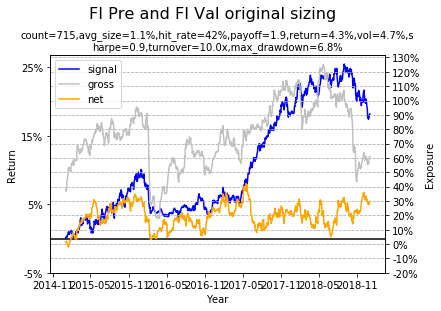

In [92]:
plot_signal('FI Pre and FI Val original sizing',[6,4],index_hedged_alpha_combine)

In [179]:
index_hedged_portfolio_combine=signal_combine([Europe_center_book_orig.index_hedged_portfolio,
                US_center_book_orig.index_hedged_portfolio,
                Asia_center_book_orig.index_hedged_portfolio]
               ,1000000000,1000000000)

In [180]:
trading_analytics(index_hedged_portfolio_combine[0])

(726,
 0.4256198347107438,
 1.9400764117040727,
 0.04927679647658034,
 0.039335852166490576,
 1.2527196885938638,
 0.06082949198597143)

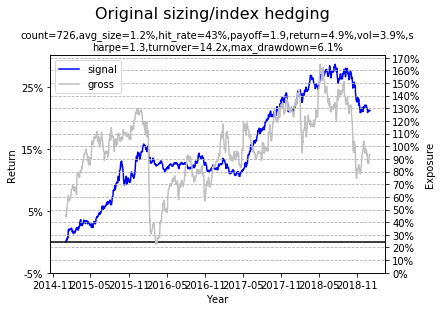

In [181]:
plot_signal('Original sizing/index hedging',[6,4],index_hedged_portfolio_combine)

In [81]:
factor_hedged_portfolio_combine=signal_combine([Europe_center_book_orig.factor_hedged_portfolio,
                US_center_book_orig.factor_hedged_portfolio,
                Asia_center_book_orig.factor_hedged_portfolio]
               ,1000000000,1000000000)

In [82]:
trading_analytics(factor_hedged_portfolio_combine[0])

(964,
 0.4336099585062241,
 1.5218894138733963,
 0.02786737710208409,
 0.029660993473883686,
 0.9395294573198008,
 0.05325543303171221)

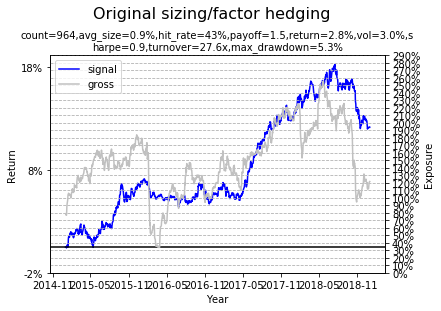

In [171]:
plot_signal('Original sizing/factor hedging',[6,4],factor_hedged_portfolio_combine)

In [101]:
index_hedged_alpha_equal_combine=signal_combine([Europe_center_book_equal.index_hedged_alpha,
                US_center_book_equal.index_hedged_alpha,
                Asia_center_book_equal.index_hedged_alpha]
               ,1000000000,1000000000)

In [102]:
trading_analytics(index_hedged_alpha_equal_combine[0])

(720,
 0.4791666666666667,
 1.4098377651214395,
 0.036608579419554754,
 0.047201601656701626,
 0.7755791781348824,
 0.07634435830540509)

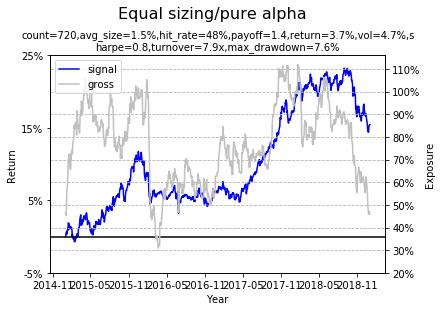

In [172]:
plot_signal('Equal sizing/pure alpha',[6,4],index_hedged_alpha_equal_combine)

In [176]:
index_hedged_portfolio_equal_combine=signal_combine([Europe_center_book_equal.index_hedged_portfolio,
                US_center_book_equal.index_hedged_portfolio,
                Asia_center_book_equal.index_hedged_portfolio]
               ,1000000000,1000000000)

In [177]:
trading_analytics(index_hedged_portfolio_equal_combine[0])

(726,
 0.47107438016528924,
 1.556526297854126,
 0.04664683388763269,
 0.03848654087603843,
 1.2120297856301974,
 0.0499194456453429)

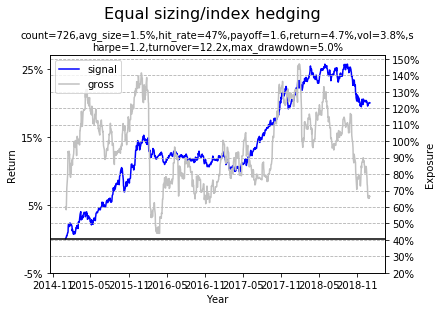

In [182]:
plot_signal('Equal sizing/index hedging',[6,4],index_hedged_portfolio_equal_combine)

In [183]:
factor_hedged_portfolio_equal_combine=signal_combine([Europe_center_book_equal.factor_hedged_portfolio,
                US_center_book_equal.factor_hedged_portfolio,
                Asia_center_book_equal.factor_hedged_portfolio]
               ,1000000000,1000000000)

In [184]:
trading_analytics(factor_hedged_portfolio_equal_combine[0])

(964,
 0.45954356846473027,
 1.3515444699021646,
 0.02660354573481838,
 0.02863986843617744,
 0.9288990204023839,
 0.04553261233940553)

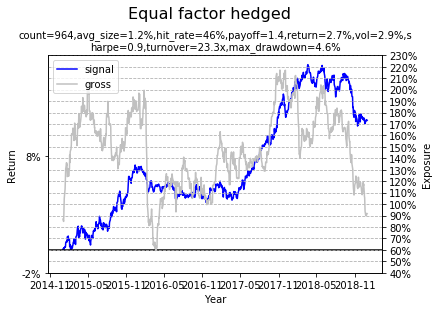

In [185]:
plot_signal('Equal factor hedged',[6,4],factor_hedged_portfolio_equal_combine)

In [83]:
index_hedged_alpha_rp_combine=signal_combine([Europe_center_book_rp.index_hedged_alpha,
                US_center_book_rp.index_hedged_alpha,
                Asia_center_book_rp.index_hedged_alpha]
               ,1000000000,1000000000)

In [84]:
trading_analytics(index_hedged_alpha_rp_combine[0])

(720,
 0.48055555555555557,
 1.5039604733378134,
 0.05056004733172359,
 0.04914141216582175,
 1.0288684248860174,
 0.07356974832821805)

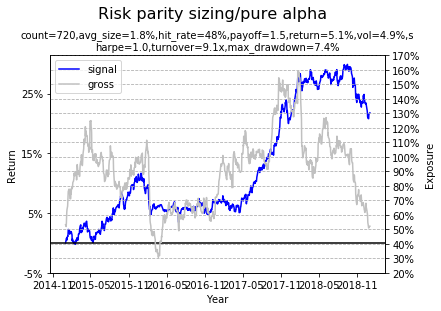

In [186]:
plot_signal('Risk parity sizing/pure alpha',[6,4],index_hedged_alpha_rp_combine)

In [112]:
index_hedged_alpha_rp_combine=signal_combine([Europe_center_book_rp.index_hedged_alpha,
                US_center_book_rp.index_hedged_alpha,
                Asia_center_book_rp.index_hedged_alpha]
               ,1000000000,700000000)

In [114]:
index_hedged_alpha_rp_combine[2]

1COV GR    AALB NA    ABBN SW     ABF LN                        \
           2017-01-04 2016-01-15 2015-10-12 2015-09-30 2016-01-14 2016-06-28   
2015-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-09        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-12        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-13        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-14        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-15        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-16        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-19        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-20        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-21        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-22        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-23        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-26        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-27        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-28        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-29        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-30        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-02        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-03        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-04        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-05        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-06        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-09        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-10        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-11        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-12        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2018-11-20        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-21        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-22        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-23        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-26        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-27        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-28        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-29        NaN        NaN        NaN        NaN        NaN        NaN   
2018-11-30        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-04        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-07        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-10        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-11        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-12        NaN        NaN        NaN        NaN        NaN        NaN   
2018-12-13    

In [96]:
index_hedged_portfolio_rp_combine=signal_combine([Europe_center_book_rp.index_hedged_portfolio,
                US_center_book_rp.index_hedged_portfolio,
                Asia_center_book_rp.index_hedged_portfolio]
               ,1000000000,700000000)

In [212]:
np.abs(index_hedged_portfolio_rp_combine[2]).sum(axis=1).mean()

0.786782535584622

In [214]:
abs(alpha_FI_size).sum(axis=1).mean()

0.7730280471159968

In [ ]:
np.abs(index_hedged_portfolio_o[2]).sum(axis=1).mean()

In [70]:
trading_analytics(index_hedged_portfolio_rp_combine[0])

(726,
 0.4724517906336088,
 1.6518216237091063,
 0.043518907294510356,
 0.030895613049138203,
 1.4085788563345651,
 0.038365134362353115)

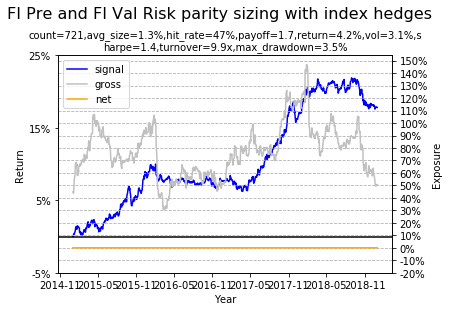

In [97]:
plot_signal('FI Pre and FI Val Risk parity sizing with index hedges',[6,4],index_hedged_portfolio_rp_combine)

In [87]:
factor_hedged_portfolio_rp_combine=signal_combine([Europe_center_book_rp.factor_hedged_portfolio,
                US_center_book_rp.factor_hedged_portfolio,
                Asia_center_book_rp.factor_hedged_portfolio]
               ,1000000000,1000000000)

In [88]:
trading_analytics(factor_hedged_portfolio_rp_combine[0])

(964,
 0.4678423236514523,
 1.3726891829987402,
 0.039360593074069694,
 0.031469821914480306,
 1.2507408901465242,
 0.04031838133772936)

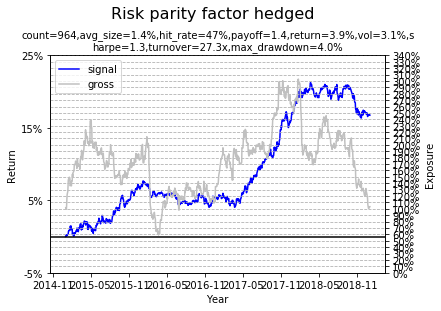

In [190]:
plot_signal('Risk parity factor hedged',[6,4],factor_hedged_portfolio_rp_combine)